# Exploration 06
## 네이버 영화리뷰 감성 분석 도전하기

### 목차
- 모듈 임포트
- 데이터 준비와 확인 
- 데이터로더 구성
- 모델 구성을 위한 데이터 분석 및 가공
- 모델 구성 및 validation set구성
- 모델 훈련 개시
- Loss, Accurancy
- 학습된 Embedding 레이어 분석
- 한국어 Word2Vec 임베딩 활용하여 성능 개선

## 모듈 임포트

In [1]:
import os
import tensorflow as tf
import pandas as pd
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import gensim
from tensorflow.keras.initializers import Constant

import warnings
warnings.filterwarnings("ignore")

## 데이터 준비와 확인

데이터 로드전 github를 통한 데이터 확인 
      
- columns: [id, document, label]
     - id: Naver가 제공한 리뷰 id
     - document: 실제 리뷰
     - label: 리뷰의 감정 class(0: 부정, 1: 긍정)
- 200k(20만)개의 리뷰
    - ratings.txt: 전체 20만개 리뷰
    - ratings_test.txt: test를 위한 50000개의 리뷰
    - ratings_train.txt: train를 위한 150000개의 리뷰

In [2]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터로더 구성 
과정
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    
    # 결측치 제거
    train_data = train_data.dropna(how = 'any') 
    test_data = test_data.dropna(how = 'any') 
    
    # 한국어 토크나이저로 토큰화 작업
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

Load train, test, word_to_index 

In [4]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

Delete empty sample

In [5]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

146179
146179


Create index_to_word 

In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}

check word_to_index

In [7]:
word_to_index.values()# 3부터 시작

dict_values([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 2

Insert padding, start, unknown word

In [8]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2 
index_to_word = {index:word for word, index in word_to_index.items()}

Check word_to_index, index_to_word

In [9]:
print(word_to_index['<PAD>'])
print(index_to_word[0])
print(index_to_word[1])
print(index_to_word[2])
print(index_to_word[6]) # index=6 -> '다'
print(word_to_index['다'])

0
<PAD>
<BOS>
<UNK>
다
6


Create encode_func, decode_func

In [10]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

Check encode_func, decode_fuc

In [11]:
# encode된 숫자 텍스트 데이터 decode 동작 확인
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


## 모델 구성을 위한 데이터 분석 및 가공
과정 
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

Calculation mean, max, std

In [12]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.969647172052259
문장길이 최대 :  116
문장길이 표준편차 :  12.843517339754191


Init maxlen

In [13]:
# 최대 길이: (평균 + 2*표준편차)
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다.')

pad_sequences maxlen :  41
전체 문장의 0.9342978252856616%가 maxlen 설정값 이내에 포함됩니다.


Add padding to train data, test data

In [14]:
# padding 방식 결정
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(x_train.shape)

(146179, 41)


## 모델 구성 및 validation set 구성
모델 3가지
- RNN(LSTM layer)
- CNN(Conv layer)
- Only Pooling

RNN(LSTM layer)

In [15]:
vocab_size = 10000    # 어휘 사전의 크기입니다(30,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model_RNN = tf.keras.Sequential()

model_RNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_RNN.add(tf.keras.layers.LSTM(128))  
model_RNN.add(tf.keras.layers.Dense(32, activation='relu'))
model_RNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_RNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               74240     
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 238,401
Trainable params: 238,401
Non-trainable params: 0
_________________________________________________________________


CNN(Conv layer)

In [16]:
vocab_size = 10000     # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_CNN = tf.keras.Sequential()
model_CNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_CNN.add(tf.keras.layers.Conv1D(64, 7, activation='relu'))
model_CNN.add(tf.keras.layers.Dropout(0.3))
model_CNN.add(tf.keras.layers.MaxPooling1D(5))
model_CNN.add(tf.keras.layers.Conv1D(64, 7, activation='relu'))
model_CNN.add(tf.keras.layers.Dropout(0.3))
model_CNN.add(tf.keras.layers.GlobalMaxPooling1D())
model_CNN.add(tf.keras.layers.Dense(8, activation='relu'))
model_CNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          7232      
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          28736     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
global_max_pooling1d (Global (None, 64)               

Only Pooling

In [17]:
vocab_size = 10000     # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_Pool = tf.keras.Sequential()
model_Pool.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_Pool.add(tf.keras.layers.GlobalMaxPooling1D())
model_Pool.add(tf.keras.layers.Dense(8, activation='relu'))
model_Pool.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_Pool.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [18]:
models = [model_RNN, model_CNN, model_Pool]

validation set

In [19]:
# validation set 40000건 분리
x_val = x_train[:40000]   
y_val = y_train[:40000]

# validation set을 제외한 나머지 106182건
partial_x_train = x_train[40000:]  
partial_y_train = y_train[40000:]

print(f'x_val.shape: {x_val.shape}')
print(f'y_val.shape: {y_val.shape}')
print(f'partial_x_train.shape: {partial_x_train.shape}')
print(f'partial_x_train.shape: {partial_x_train.shape}')

x_val.shape: (40000, 41)
y_val.shape: (40000,)
partial_x_train.shape: (106179, 41)
partial_x_train.shape: (106179, 41)


## 모델 훈련 개시

In [20]:
def train_model(model, epochs):
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
 
    print(f'model: {model.name} start')
    history = model.fit(partial_x_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=1)
    return history

In [21]:
historys = []

epochs = 10

for i, model in enumerate(models):
    historys.append(train_model(model, epochs))
    print(f'model: {model.name} end!')

model: sequential start
Epoch 1/10
208/208 [==============================] - 6s 12ms/step - loss: 0.4595 - accuracy: 0.7802 - val_loss: 0.3557 - val_accuracy: 0.8454
Epoch 2/10
208/208 [==============================] - 2s 10ms/step - loss: 0.3350 - accuracy: 0.8576 - val_loss: 0.3484 - val_accuracy: 0.8498
Epoch 3/10
208/208 [==============================] - 2s 9ms/step - loss: 0.3176 - accuracy: 0.8682 - val_loss: 0.3583 - val_accuracy: 0.8423
Epoch 4/10
208/208 [==============================] - 2s 10ms/step - loss: 0.3052 - accuracy: 0.8733 - val_loss: 0.3508 - val_accuracy: 0.8470
Epoch 5/10
208/208 [==============================] - 2s 10ms/step - loss: 0.2920 - accuracy: 0.8788 - val_loss: 0.3461 - val_accuracy: 0.8499
Epoch 6/10
208/208 [==============================] - 2s 10ms/step - loss: 0.2741 - accuracy: 0.8859 - val_loss: 0.3530 - val_accuracy: 0.8505
Epoch 7/10
208/208 [==============================] - 2s 10ms/step - loss: 0.2540 - accuracy: 0.8936 - val_loss: 0.3468

Predict model

In [22]:
def predict_model(model):
    results = model.evaluate(x_test,  y_test, verbose=2)

    print(results)

In [23]:
for i, model in enumerate(models):
    print(f'model: {model.name}')
    predict_model(model)
    print("")

model: sequential
1537/1537 - 3s - loss: 0.4121 - accuracy: 0.8440
[0.4120548963546753, 0.8439896702766418]

model: sequential_1
1537/1537 - 3s - loss: 0.4876 - accuracy: 0.8356
[0.4875582754611969, 0.8356490135192871]

model: sequential_2
1537/1537 - 2s - loss: 0.4160 - accuracy: 0.8370
[0.4159926176071167, 0.8369713425636292]



## Loss, Accurancy 그래프 시각화

In [24]:
def show_history(history):
    history_dict = history.history

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12,5))
    
    # loss, epoch
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, 'r', label='Training loss')
    
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # accurancy, epoch
    plt.subplot(1,2,2)
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

sequential


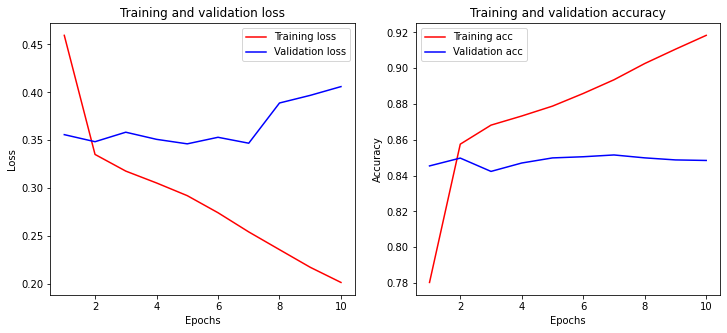

sequential_1


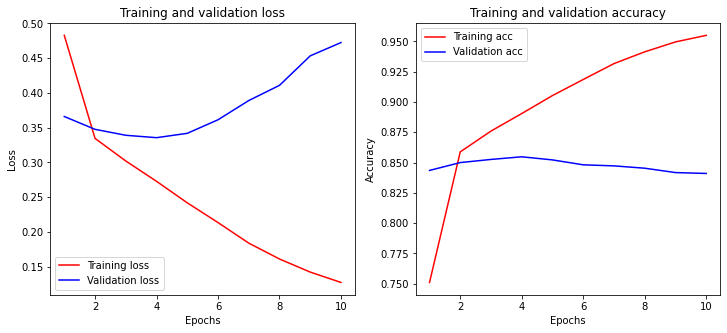

sequential_2


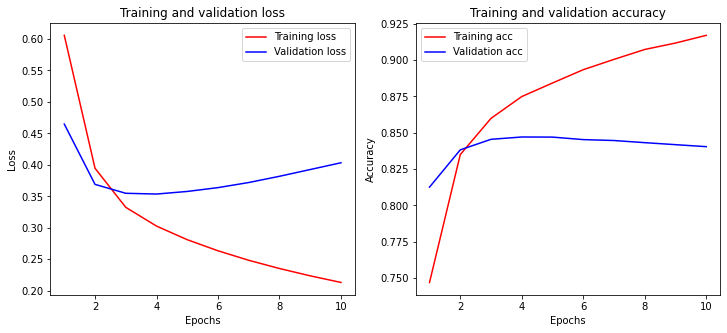

In [25]:
for i, history in enumerate(historys):
    print(models[i].name)
    show_history(history)

## 학습된 Embedding 레이어 분석

Check Embedding layer

In [26]:
def check_embedding_layer(model):
    embedding_layer = model.layers[0]
    weights = embedding_layer.get_weights()[0]
    print(weights.shape) # shape: (vocab_size, embedding_dim)

In [27]:
for i, model in enumerate(models):
    check_embedding_layer(model)

(10000, 16)
(10000, 16)
(10000, 16)


Store Embedding paramter

In [28]:
def store_vector(idx, model):
    # 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
    word2vec_file_path = os.getenv('HOME')+f'/aiffel/sentiment_classification/data/word2vec{idx}.txt'
    f = open(word2vec_file_path, 'w')
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
    vectors = model.get_weights()[0]
    for i in range(4,vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
    f.close()

In [29]:
for i, model in enumerate(models):
    store_vector(i, model)

Load Embedding vector

In [30]:
word_vectors_list = []

for idx in range(3):
    word_vectors_list.append(Word2VecKeyedVectors.load_word2vec_format(os.getenv('HOME')+f'/aiffel/sentiment_classification/data/word2vec{idx}.txt', binary=False))

for i, word_vectors in enumerate(word_vectors_list):
    vector = word_vectors['별로']
    print(vector)

[ 0.10296919 -0.12289058 -0.15550257 -0.16824244  0.12578604 -0.1189964
  0.1202007  -0.15688492 -0.1920249   0.13349959 -0.12582253  0.16207397
  0.14645253 -0.08782657  0.20087892 -0.19943422]
[-0.15368326 -0.02982786  0.07749946 -0.15569088  0.14001319 -0.03677756
  0.14361706  0.17228079  0.02794495  0.00279532  0.03690867 -0.11197639
  0.1685739   0.11820269  0.15625088  0.16905671]
[-0.01896283  0.202837   -0.16312292 -0.14222115  0.14211689 -0.04615879
 -0.06584326 -0.12271103 -0.14451048  0.17371608  0.17661373 -0.01329284
  0.00431487 -0.02395588 -0.14280921 -0.13902706]


Check Similarity

In [31]:
for i, word_vectors in enumerate(word_vectors_list):
    print(f"word_vector{i+1}")
    for i in word_vectors.similar_by_word("별로"):
        print(i)
    print('')

word_vector1
('과대평가', 0.9864777326583862)
('방어', 0.9806520938873291)
('왜곡', 0.9765040874481201)
('단조', 0.9761885404586792)
('짝퉁', 0.9705866575241089)
('지겹', 0.9680154323577881)
('구림', 0.9652817845344543)
('별루', 0.9650372862815857)
('나열', 0.9646371006965637)
('개뿔', 0.9645885229110718)

word_vector2
('낚시', 0.9486520290374756)
('쓰레기', 0.932060718536377)
('실망감', 0.9291424751281738)
('재미없', 0.9221245050430298)
('단조', 0.9209360480308533)
('태국', 0.9161849021911621)
('비추', 0.9144784212112427)
('유치', 0.9103507995605469)
('그다지', 0.9094391465187073)
('티라노', 0.9091205596923828)

word_vector3
('빈약', 0.9165151119232178)
('몫', 0.8857821226119995)
('--;', 0.8753262758255005)
('OOO', 0.8669649958610535)
('개고생', 0.8617873787879944)
('동네', 0.8614015579223633)
('뒷맛', 0.8580467700958252)
('뽕', 0.8565047383308411)
('관심없', 0.8495404720306396)
('전반부', 0.8481157422065735)



## 한국어 Word2Vec 임베딩 활용하여 성능 개선
Word2Vec info
- Country: korea
- Vetor Size: 200
- Corpus Size: 339M
- Vocabulary Size: 30185

gensim version이 4.x.x이상부터 Vocab이 사라져서 3.x.x버전을 사용해야 error가 나지 않는다.

In [32]:
%%bash
pip list | grep gensim

gensim                        3.8.3


Load word2vec

In [33]:
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin' 
word2vec = gensim.models.Word2Vec.load(word2vec_path)

vector = word2vec['별로']
vector     

array([ 1.68665443e-02,  9.18045640e-01, -7.20242500e-01, -6.83554351e-01,
       -7.34229505e-01, -1.07350506e-01,  2.57092088e-01, -1.41239154e+00,
       -3.28814447e-01, -6.70715988e-01, -4.99807000e-01, -5.01364708e-01,
       -2.17055273e+00, -3.73479307e-01, -1.49181628e+00, -3.28086883e-01,
        5.54419219e-01,  4.73109990e-01,  1.62339854e+00, -6.64335668e-01,
       -8.94197702e-01, -1.89828143e-01, -1.38139045e+00,  6.56678617e-01,
        2.29216886e+00, -4.25388277e-01, -2.65674204e-01,  1.07140839e-01,
        9.34884489e-01, -1.97074771e+00, -4.77636695e-01, -9.96400058e-01,
        3.80843103e-01,  1.03787982e+00, -1.42434752e+00,  1.64766729e+00,
        2.95337319e-01, -5.24710536e-01,  3.63458037e-01, -5.67891061e-01,
       -9.78340745e-01, -3.71020913e-01, -8.24937448e-02,  4.88069862e-01,
       -1.22962976e+00,  7.26849496e-01,  2.58719295e-01, -8.65202069e-01,
       -7.28265718e-02, -8.48643005e-01,  1.60336983e+00,  1.62154436e-01,
       -2.55368757e+00, -

Check Similarity

In [34]:
word2vec.similar_by_word("별로")

[('그다지', 0.516608476638794),
 ('지역별', 0.49092748761177063),
 ('전혀', 0.48824024200439453),
 ('각기', 0.4875951111316681),
 ('개별', 0.47797343134880066),
 ('따로', 0.4700734317302704),
 ('마다', 0.46785035729408264),
 ('별', 0.45661038160324097),
 ('딱히', 0.4535921812057495),
 ('다소', 0.43761277198791504)]

Change Embedding layer

In [35]:
vocab_size = 10000    
word_vector_dim = 200  
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

model 

In [54]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 35, 16)            22416     
_________________________________________________________________
dropout_10 (Dropout)         (None, 35, 16)            0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 1, 16)             1808      
_________________________________________________________________
dropout_11 (Dropout)         (None, 1, 16)             0         
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 16)               

Train

In [55]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
208/208 [==============================] - 2s 8ms/step - loss: 0.6531 - accuracy: 0.5891 - val_loss: 0.5308 - val_accuracy: 0.7505
Epoch 2/10
208/208 [==============================] - 1s 7ms/step - loss: 0.4754 - accuracy: 0.7782 - val_loss: 0.4205 - val_accuracy: 0.8188
Epoch 3/10
208/208 [==============================] - 1s 7ms/step - loss: 0.3929 - accuracy: 0.8298 - val_loss: 0.3821 - val_accuracy: 0.8387
Epoch 4/10
208/208 [==============================] - 1s 7ms/step - loss: 0.3527 - accuracy: 0.8508 - val_loss: 0.3679 - val_accuracy: 0.8468
Epoch 5/10
208/208 [==============================] - 1s 7ms/step - loss: 0.3258 - accuracy: 0.8639 - val_loss: 0.3534 - val_accuracy: 0.8471
Epoch 6/10
208/208 [==============================] - 1s 7ms/step - loss: 0.3079 - accuracy: 0.8729 - val_loss: 0.3480 - val_accuracy: 0.8523
Epoch 7/10
208/208 [==============================] - 1s 7ms/step - loss: 0.2913 - accuracy: 0.8808 - val_loss: 0.3562 - val_accuracy: 0.8515
Epoch 

Test

In [56]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3505 - accuracy: 0.8509
[0.35051387548446655, 0.8509266376495361]


Visualization

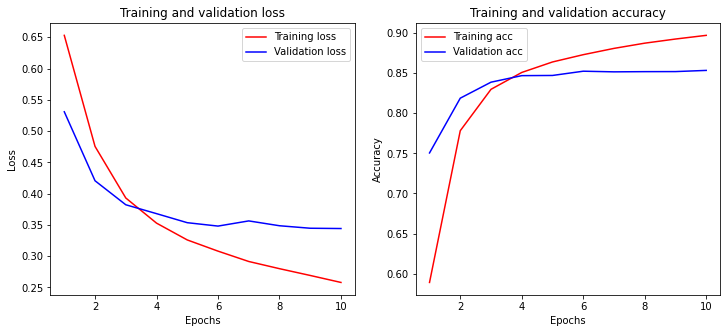

In [59]:
show_history(history)

## 결과 분석 
---

###  내가 만든 모델 분석
info 
- epochs: 10
- optimizer: adam
- loss: binary_crossentropy
- metrics: accuracy
       
|model|loss|accurancy|
|---|---|---|
|RNN(LSTM layer)|0.4121|0.8440|    
|CNN(ConV layer)|0.4876|0.8356|   
|POOLing|0.4160|0.8370|            
              
3개의 모델 중 가장 좋은 모델은 RNN(LSTM layer)를 활용한 모델이었다. 하지만 loss, accurancy 그래프들을 시각화한 결과 모두 오버피팅이 일어나고 있는 것이 관찰되었다. 이것을 해결하기 위해 다음과 같은 방법을 생각해 보았다.
- 드롭아웃 (적용했지만 효과가 크게 없었다.)
- LSTM layer의 히든레이어 개수 추가 (적용했지만 크게 효과가 없었다.)
- 모델의 layer층 늘리기 (특징들을 더욱 세밀하게 잡기위해 했지만 dimention이 어떻게 이루어지는지 잘 이해를 못해서 적용하지 못하였다.)

### 한국어 Embedding vector 활용 모델 분석
info
- epochs: 10
- optimizer: adam
- loss: binary_crossentropy
- metrics: accuracy
- embeddings_initializer: embedding_matrix(카피한 임베딩)
- trainable: True
        
|model|loss|accurancy|
|---|---|---|
|CNN(ConV layer)|0.3505|0.8509|        
         
처음에는 만든 모델처럼 3개의 모델로 학습 및 평가를 진행하였다. 하지만 만든 모델처럼 오버피팅이 일어나는 상황이 벌어졌다. 그래서 오버피팅을 억제하는 방법인 드롭아웃을 적용하였더니 loss, accurancy그래프가 좋아지는 것을 볼 수 있었다. __최종적으로 accurancy: 0.8509__라는 값을 얻었다.

### 부수적인 내용
- padding: pre와 post를 둘 다 적용해봤지만 둘의 차이가 거의 없어 노드에서 좋다고 했던 pre를 사용하였다.
- gensim: gensim패키지를 적용할 때 3.x.x버전으로 바꿨지만 오류가 나는 상황이 발생하였다. 그래서 gensim의 버전을 3.0.0부터 하나씩 올려가며 패키지를 적용해서 3.8.3에서 적용되었다. (3.8.0은 안됬음, 아직도 이유를 모르겠음)

### 